# plot_theory_vs_profile
### dataset (3 mins per date)
- 20180517
- 20180621
- 20180816

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random
import json
import os

from result_plots.ProfilingBased.common.common import read_data, get_metric_mapping
from result_plots.ProfilingBased.common.plot import get_result_from_pkl, get_x_position, get_xtick_position

---

## Define profiling functions

In [2]:
def get_counter_size(algo = 'cm'):
    counter_size = 4
    if algo == 'hll' or algo == 'll':
        # int8
        counter_size = 1
    elif algo == 'lc' or algo == 'mrb':
        # 1 bit
        counter_size = 1/8
    return counter_size

# The original width is the number of counter, so it needs to multiply the size of the counter
def convert_width_to_real_byte(algo = 'cm', widths = [4096, 8192, 16384, 32768, 65536, 131072]):
    np_arr = np.array(widths)
    counter_size = get_counter_size(algo)
    return (np_arr * counter_size).astype(np.int32).tolist()

In [2]:
def dump_json(data, algo = 'cm', rows = [1, 2, 3, 4, 5], widths = [4096, 8192, 16384], level=1, \
              measure_list = ['hh', 'entropy'], isDumpJson=False, output_dir_name = 'profiler'):
    counter_size = get_counter_size(algo)
    # key: metric, row, width
    ret = {}
    for m in measure_list:
        ret[m] = {}
        for r in rows:
            ret[m][r] = {}
            for w in widths:
                ret[m][r][w] = data[m][r][int(w/counter_size)]
    
    if isDumpJson:
        output_dir = f'results/{output_dir_name}/'
        # create directory if it doesn't exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        # with open(f'results/num_of_pcaps/pcap_3/{algo}_level_{level}_result.json', 'w') as f:
        # with open(f'results/profiler_diff_dataset/{algo}_level_{level}_result.json', 'w') as f:
        with open(f'{output_dir}/{algo}_level_{level}_result.json', 'w') as f:
            json.dump(ret, f)
    
    return ret

In [3]:
# get mean value for all list in the same row size & col size & metric
def get_mean_value(ret, rows = [1, 2, 3, 4, 5], measure_list = ['hh', 'entropy']):
    # key: metric, row
    # mean value of the same column 
    data = {}
    for m in measure_list:
        data[m] = {}
        for r in rows:
            data[m][r] = []
            for w in ret[m][r]:
                data[m][r].append(np.mean(ret[m][r][w]))
    return data

# mean_data = get_mean_value(ret)
# mean_data['entropy']

In [4]:
# # plot profiling result (mean value) for all metrics with different rows
# def plot_result(data, algo = 'cm', rows = [1, 2, 3, 4, 5], widths = [4096, 8192, 16384, 32768, 65536, 131072],
#                level = 1, measure_list = ['hh', 'entropy'], isSaveFig=False, isShowByte=False, output_dir_name='profiler'):
#     x_labels = []
#     if isShowByte:
#         for w in widths:
#             x_labels.append(str(w))
#     else:
#         for w in widths:
#             x_labels.append(str(int(w / 1024)))

#     for m in measure_list:
#         fig = plt.figure(figsize = (7, 5))

#         # Creating axes instance
#         ax = fig.add_axes([0, 0, 1, 1])

#         # Creating plot
#         for r in rows:
#             bp = ax.plot(widths, data[m][r], label=f'row: {r}')

#         # plt.axvline(x = 8192, color = 'darkgreen', linestyle='--')

#         ax.set_xticks(widths)
#         if isShowByte:
#             ax.set_xticklabels(x_labels, fontsize=14, rotation = 45)
#             plt.xlabel("Width (BYTE)", fontsize=16)
#         else:
#             ax.set_xticklabels(x_labels, fontsize=14)
#             plt.xlabel("Width (KB)", fontsize=16)
            
#         plt.yticks(fontsize=14)
            
#         title_str = ''
#         ylabel_str = ''
#         ylabel_fontsize = 16
#         if m == 'hh':
#             title_str = f'{algo.upper()}: Heavy Hitter'
#             ylabel_str = "Average Relative Error (%)"
#         elif m == 'entropy':
#             title_str = f'{algo.upper()}: Entropy'
#             ylabel_str = "Relative Error (%)"
#         elif m == 'card':
#             title_str = f'{algo.upper()}: Cardinality'
#             ylabel_str = "Relative Error (%)"
#         elif m == 'fsd':
#             title_str = f'{algo.upper()}: Flow Size Distribution'
#             ylabel_str = "Weighted Mean Relative Difference (WMRD)"
#             ylabel_fontsize = 14
#         elif m == 'change_det':
#             title_str = f'{algo.upper()}: Change Detection'
#             ylabel_str = "Average Relative Error (%)"

#         if level > 1:
#             title_str += f', Level: {level}'
#         plt.title(title_str, fontsize=18)
#         plt.ylabel(ylabel_str, fontsize=ylabel_fontsize)

#         # legend_patch = []
#         # legend_patch.append(mpatches.Patch(color='crimson', label='Best algorithms'))
#         # legend_patch.append(mpatches.Patch(color='royalblue', label='General algorithm'))
#         # plt.legend(handles=legend_patch, fontsize=16)
#         plt.legend(fontsize=16)
        
#         if isSaveFig:
#             output_dir = f'figures/{output_dir_name}/'
#             # create directory if it doesn't exist
#             if not os.path.exists(output_dir):
#                 os.makedirs(output_dir)
            
#             plt.savefig(f'{output_dir}/{algo.upper()}_{m}_profiling.pdf', format='pdf', bbox_inches='tight')
        
#         # show plot
#         plt.show()
        
# # plot_result(mean_data)

In [5]:
def plot_result(data, algo = 'cm', rows = [1, 2, 3, 4, 5], widths = [4096, 8192, 16384, 32768, 65536, 131072],
               level = 1, measure_list = ['hh', 'entropy'], isSaveFig=False, isShowByte=False, output_dir_name='profiler'):
    x_labels = []
    if isShowByte:
        for w in widths:
            x_labels.append(str(w))
    else:
        for w in widths:
            x_labels.append(str(int(w / 1024)))

    fig = plt.figure(figsize = (7, 5))

    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    print(data['theoretical_error_bound'][rows[0]])
    # Creating plot
    bp = ax.plot(widths, data['theoretical_error_bound'][rows[0]], label=f'theoretical', marker='o')
    bp = ax.plot(widths, data['actual_error_bound'][rows[0]], label=f'actual', marker='x')
    
    ax.set_yscale('log')
    ax.set_ylim([10**2, 10**6])

    title_str = f'Theoretical vs. Acutal\n{algo.upper()}: error bound with delta = 0.05 (row = 3)'
    plt.title(title_str, fontsize=18)

    plt.yticks(fontsize=14)
    ylabel_str = 'Error bound (# of packet)'
    ylabel_fontsize = 18
    plt.ylabel(ylabel_str, fontsize=ylabel_fontsize)

    ax.set_xticks(widths)
    ax.set_xticklabels(x_labels, fontsize=14)
    plt.xlabel("Width (KB)", fontsize=16)

    plt.legend(fontsize=16)

    if isSaveFig:
        output_dir = f'figures/{output_dir_name}/'
        # create directory if it doesn't exist
        # if not os.path.exists(output_dir):
        #     os.makedirs(output_dir)

        # plt.savefig(f'{output_dir}/{algo.upper()}_{m}_profiling.pdf', format='pdf', bbox_inches='tight')

In [26]:
# # plot profiling result (mean value) for all metrics with different rows
# def plot_result_for_overleaf(data, algo = 'cm', rows = [1, 2, 3, 4, 5], widths = [4096, 8192, 16384, 32768, 65536, 131072],
#                level = 1, measure_list = ['hh', 'entropy'], isSaveFig=False, isShowByte=False, output_dir_name='profiler'):
#     x_labels = []
#     if isShowByte:
#         for w in widths:
#             x_labels.append(str(w))
#     else:
#         for w in widths:
#             x_labels.append(str(int(w / 1024)))
            
#     marker_list = ["o", "s", "^", "x", 'p']

#     for m in measure_list:
#         fig = plt.figure(figsize = (10, 6))

#         # Creating axes instance
#         ax = fig.add_axes([0, 0, 1, 1])

#         # Creating plot
#         for i, r in enumerate(rows):
#             bp = ax.plot(widths, data[m][r], label=f'Number of rows: {r}',
#                         linewidth='2', marker=marker_list[i])

#         # plt.axvline(x = 8192, color = 'darkgreen', linestyle='--')

#         ax.set_xticks(widths)
#         if isShowByte:
#             ax.set_xticklabels(x_labels, fontsize=20, rotation = 45)
#             plt.xlabel("Width (BYTE)", fontsize=30)
#         else:
#             ax.set_xticklabels(x_labels, fontsize=20)
#             plt.xlabel("Width of each row (KB)", fontsize=28)
            
#         plt.yticks(fontsize=26)    
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
            
#         title_str = ''
#         ylabel_str = ''
#         ylabel_fontsize = 28
#         if m == 'hh':
#             title_str = f'{algo.upper()}: Heavy Hitter'
#             ylabel_str = "Average Relative Error (%)"
#         elif m == 'entropy':
#             title_str = f'{algo.upper()}: Entropy'
#             ylabel_str = "Relative Error (%)"
#         elif m == 'card':
#             title_str = f'{algo.upper()}: Cardinality'
#             ylabel_str = "Relative Error (%)"
#         elif m == 'fsd':
#             title_str = f'{algo.upper()}: Flow Size Distribution'
#             ylabel_str = "Weighted Mean Relative Difference (WMRD)"
#             ylabel_fontsize = 14
#         elif m == 'change_det':
#             title_str = f'{algo.upper()}: Change Detection'
#             ylabel_str = "Average Relative Error (%)"

#         if level > 1:
#             title_str += f', Level: {level}'
#         # plt.title(title_str, fontsize=18)
#         plt.ylabel(ylabel_str, fontsize=ylabel_fontsize)

#         # legend_patch = []
#         # legend_patch.append(mpatches.Patch(color='crimson', label='Best algorithms'))
#         # legend_patch.append(mpatches.Patch(color='royalblue', label='General algorithm'))
#         # plt.legend(handles=legend_patch, fontsize=16)
#         plt.legend(fontsize=22, frameon=False)
        
#         if isSaveFig:
#             output_dir = f'figures/{output_dir_name}/overleaf'
#             # create directory if it doesn't exist
#             if not os.path.exists(output_dir):
#                 os.makedirs(output_dir)
            
#             plt.savefig(f'{output_dir}/{algo.upper()}_{m}_profiling.pdf', format='pdf', bbox_inches='tight')
        
#         # show plot
#         plt.show()
        
# # plot_result(mean_data)

In [27]:
# # plot profiling result (mean value) for all metrics with different rows
# def boxplot_result(data, algo = 'cm', rows = [1, 2, 3, 4, 5], widths = [4096, 8192, 16384, 32768, 65536, 131072],
#                level = 1, measure_list = ['hh', 'entropy'], isSaveFig=False, isShowByte=False, output_dir_name='profiler'):
#     # key of `data`: metric, row, width
#     x_labels = []
#     if isShowByte:
#         for w in widths:
#             x_labels.append(str(w))
#     else:
#         for w in widths:
#             x_labels.append(str(int(w / 1024)))

#     for m in measure_list:
#         for r in rows:
#             plot_list = []
#             for w in widths:
#                 plot_list.append(data[m][r][w])
            
#             fig = plt.figure(figsize = (10, 6))

#             # Creating axes instance
#             ax = fig.add_axes([0, 0, 1, 1])

#             # Creating plot
#             # bplot = ax.boxplot(x=plot_list, 
#             #                    positions = [1.2,1.8, 3.2,3.8, 5.2,5.8],
#             #                    patch_artist=True)
#             bplot = ax.boxplot(x=plot_list, labels=widths)

# #             ax.set_xticks([0] + widths)
#             if isShowByte:
#                 ax.set_xticklabels(x_labels, fontsize=14, rotation = 45)
#                 plt.xlabel("Width (BYTE)", fontsize=16)
#             else:
#                 ax.set_xticklabels(x_labels, fontsize=14)
#                 plt.xlabel("Width (KB)", fontsize=16)

#             plt.yticks(fontsize=14)

#             title_str = ''
#             ylabel_str = ''
#             ylabel_fontsize = 16
#             if m == 'hh':
#                 title_str = f'{algo.upper()}: Heavy Hitter, Row: {r}'
#                 ylabel_str = "Average Relative Error (%)"
#             elif m == 'entropy':
#                 title_str = f'{algo.upper()}: Entropy, Row: {r}'
#                 ylabel_str = "Relative Error (%)"
#             elif m == 'card':
#                 title_str = f'{algo.upper()}: Cardinality, Row: {r}'
#                 ylabel_str = "Relative Error (%)"
#             elif m == 'fsd':
#                 title_str = f'{algo.upper()}: Flow Size Distribution, Row: {r}'
#                 ylabel_str = "Weighted Mean Relative Difference (WMRD)"
#                 ylabel_fontsize = 14
#             elif m == 'change_det':
#                 title_str = f'{algo.upper()}: Change Detection, Row: {r}'
#                 ylabel_str = "Average Relative Error (%)"
            
#             if level > 1:
#                 title_str += f', Level: {level}'
#             plt.title(title_str, fontsize=18)
#             plt.ylabel(ylabel_str, fontsize=ylabel_fontsize)

#             # plt.legend(fontsize=16)

#             if isSaveFig:
#                 output_dir = f'figures/{output_dir_name}/boxplot/'
#                 # create directory if it doesn't exist
#                 if not os.path.exists(output_dir):
#                     os.makedirs(output_dir)
#                 plt.savefig(f'{output_dir}/{algo.upper()}_{m}_row_{r}_boxplot.pdf', format='pdf', bbox_inches='tight')

#             # show plot
#             plt.show()

In [6]:
def profiling_analysis(algos = ['cm'], rows = [1, 2, 3, 4, 5], widths = [4096, 8192, 16384, 32768, 65536, 131072], level=1, seeds=[1, 2, 3], 
                           count=1, measure_list = ['hh', 'entropy'], flowkeys = ["srcIP,srcPort", "dstIP,dstPort",], epochs = ['30'],
                     datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/'],
                     isSaveFig=False, isDumpJson=False, isBoxPlot=False, isShowByte=False, output_dir_name='profiler'): 
    
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    widths = convert_width_to_real_byte(algos[0], widths)
    byte_ret = dump_json(ret, algos[0], rows, widths, level, measure_list, isDumpJson, output_dir_name)
    mean_ret = get_mean_value(ret, rows, measure_list)
    plot_result(mean_ret, algos[0], rows, widths, level, measure_list, isSaveFig, isShowByte, output_dir_name)
    # plot_result_for_overleaf(mean_ret, algos[0], rows, widths, level, measure_list, isSaveFig, isShowByte, output_dir_name)
    # if isBoxPlot:
    #     boxplot_result(byte_ret, algos[0], rows, widths, level, measure_list, isSaveFig, isShowByte, output_dir_name)
    # return ret
    
    # print('----------------------------')
    # print(f'Complete {algos[0]} profiling')
    # print('----------------------------')

In [7]:
# tmp = profiling_analysis(['hll'], [1], [4096, 8192, 16384, 32768, 65536], 1, 3, 1, ['card'])
# tmp['hh'][1][16384]

#### Common variables

In [8]:
## Hyperparameters
isSaveFig = False
isDumpJson = False
seeds = [1, 2, 3, 4, 5]
# output_dir_name = 'profiler'

flowkeys = ["srcIP",]
# flowkeys = ['srcIP,srcPort']
# flowkeys = ["dstIP,dstPort",]
epochs = ['30']

output_dir_name = 'versus'
datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/',]

# caida
# output_dir_name = 'profiler_caida_srcip'
# datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180621-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]




---

## Measure CM

[43799.3830990298, 21899.6915495149, 10949.84577475745, 5474.922887378725, 2737.4614436893626, 1368.7307218446813]


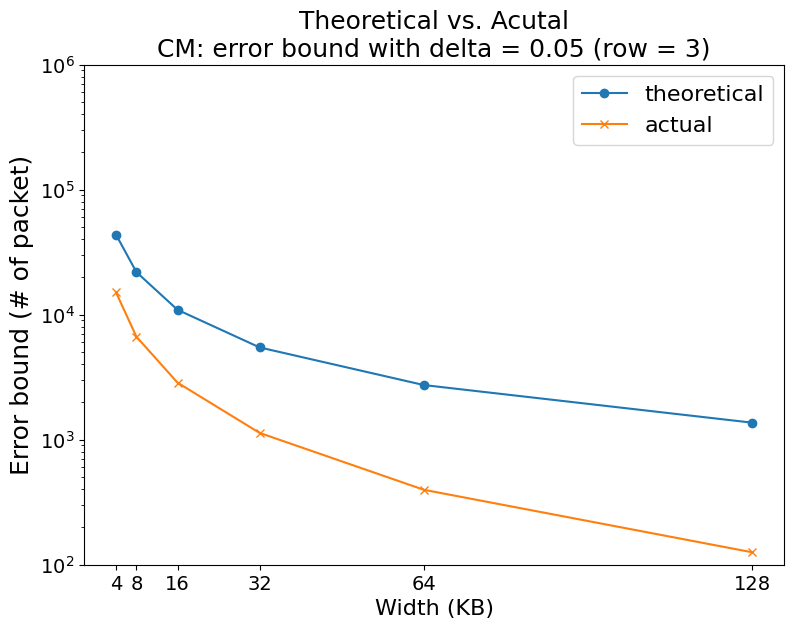

In [31]:
algos = ['cm']
rows = [3]

# widths = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]
# widths = [4096, 8192, 16384, 32768, 65536, 131072]
widths = [1024, 2048, 4096, 8192, 16384, 32768]
level = 1
count = 1
measure_list = ['theoretical_error_bound', 'actual_error_bound']
# isSaveFig = False
# isDumpJson = False
isBoxPlot = False
isShowByte = False

profiling_analysis(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets, isSaveFig, isDumpJson, isBoxPlot, isShowByte, output_dir_name)

---

## Measure CS

[515612.5625, 364593.13940872264, 257806.28125, 182296.56970436132, 128903.140625, 91148.28485218066]


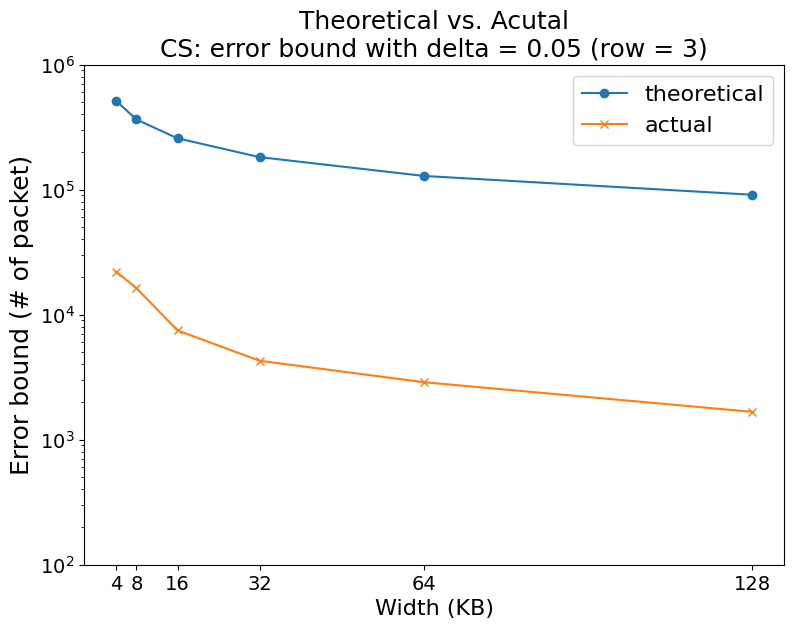

In [32]:
algos = ['cs']
rows = [3]

# widths = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]
# widths = [4096, 8192, 16384, 32768, 65536, 131072]
widths = [1024, 2048, 4096, 8192, 16384, 32768]
level = 1
count = 1
measure_list = ['theoretical_error_bound', 'actual_error_bound']
# isSaveFig = False
# isDumpJson = False
isBoxPlot = False
isShowByte = False

profiling_analysis(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets, isSaveFig, isDumpJson, isBoxPlot, isShowByte, output_dir_name)

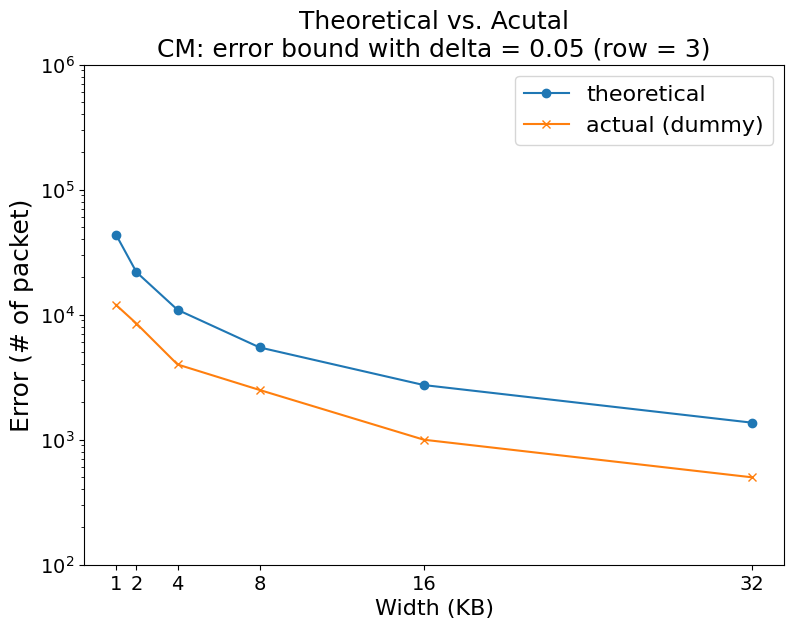

In [34]:
widths = [1024, 2048, 4096, 8192, 16384, 32768]
data = [[43799, 21899, 10949, 5474, 2737, 1368], [12000, 8500, 4000, 2500, 1000, 500]]
x_labels = [1, 2, 4, 8, 16, 32]

fig = plt.figure(figsize = (7, 5))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.plot(widths, data[0], label=f'theoretical', marker='o')
bp = ax.plot(widths, data[1], label=f'actual (dummy)', marker='x')

ax.set_yscale('log')
ax.set_ylim([10**2, 10**6])

title_str = f'Theoretical vs. Acutal\nCM: error bound with delta = 0.05 (row = 3)'
plt.title(title_str, fontsize=18)

plt.yticks(fontsize=14)
ylabel_str = 'Error (# of packet)'
ylabel_fontsize = 18
plt.ylabel(ylabel_str, fontsize=ylabel_fontsize)

ax.set_xticks(widths)
ax.set_xticklabels(x_labels, fontsize=14)
plt.xlabel("Width (KB)", fontsize=16)

plt.legend(fontsize=16)

---

## Updated version

---

## Define common functions

In [9]:
def normalize_error_result(ret_sol1, ret_us, ret_ensemble, all_metrics = ['hh', 'change_det', 'entropy', 'card', 'fsd']):
    r1 = {}
    r2 = {}
    r3 = {}
    max_list = {}
    
    for m in all_metrics:
        r1[m] = np.zeros(len(ret_sol1[m]))
        r2[m] = np.zeros(len(ret_us[m]))
        r3[m] = np.zeros(len(ret_ensemble[m]))
        
        max_list[m] = 0
        
        for i in range(len(ret_sol1[m])):
            max_list[m] = max(max_list[m], ret_sol1[m][i], ret_us[m][i])
    
    # print('max_list:', max_list)
    
    for m in all_metrics:
        for i in range(len(ret_sol1[m])):
            r1[m][i] = (ret_sol1[m][i] / max_list[m]) * 100
            r2[m][i] = (ret_us[m][i] / max_list[m]) * 100
            r3[m][i] = (ret_ensemble[m][i] / max_list[m]) * 100
    return (r1, r2, r3)

In [10]:
## Plot raw result
def plot_raw(ret_sol1, ret_us, \
             name, all_metrics = ['hh', 'change_det', 'entropy', 'card', 'fsd'], isSaveFig = False):
    ## comparison version plot
    # box plot 
    # https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
    # Box plots with custom fill colors
    # https://matplotlib.org/stable/gallery/statistics/boxplot_color.html

    import matplotlib.patches as mpatches
    
    metric_to_label = {}
    metric_to_label['hh'] = 'Heavy Hitter'
    metric_to_label['entropy'] = 'E'
    metric_to_label['card'] = 'Cardnality'
    metric_to_label['fsd'] = 'F'
    metric_to_label['change_det'] = 'D'

    xlabels = []
    for m in all_metrics:
        xlabels.append(metric_to_label[m])
    
    # colors = ['deeppink', 'darkred', 'royalblue', 'darkblue', 'darkgreen']
    colors = ['deeppink', 'darkgreen']
    colors = colors * len(xlabels)

    fig = plt.figure(figsize = (10, 6))
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])

    plot_list = []
    for m in all_metrics:
        plot_list.append(ret_sol1[m])
        plot_list.append(ret_us[m])

    # Creating plot
    bplot = ax.boxplot(x=plot_list, 
                       positions = get_x_position(len(all_metrics), 2),
                       patch_artist=True)
    # ax.set_xlim(0, 1)
    # ax.set_ylim([0, 105])

    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.ylabel("Error (%)", fontsize=30)
    plt.xlabel("Metrics", fontsize=30)
    plt.xticks([1.5, 3.5], xlabels, fontsize=26)
    plt.yticks(fontsize=26)

    # plt.title(f"Error - {name}", fontsize=18)

    # create legends
    legend_patch = []
    legend_patch.append(mpatches.Patch(color=colors[0], label='THEORY'))
    legend_patch.append(mpatches.Patch(color=colors[1], label='PROFILE'))
    plt.legend(handles=legend_patch, fontsize=14) # , loc="upper right"

    # import pickle
    # with open(f'pickles/{name}.pkl', 'wb') as fout:
    #     pickle.dump(fig, fout)
    # plt.savefig(f'figures/individual_metric/{name}.png', format='png', bbox_inches='tight')
    # plt.savefig('test.eps', format='eps', bbox_inches='tight')

    # show plot
    plt.show()
    

In [16]:

## Plot raw result
def plot_raw_with_ensemble(ret_sol1, ret_us, ret_ensemble, \
             name, all_metrics = ['hh', 'change_det', 'entropy', 'card', 'fsd'], isSaveFig = False):
    ## comparison version plot
    # box plot 
    # https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
    # Box plots with custom fill colors
    # https://matplotlib.org/stable/gallery/statistics/boxplot_color.html

    import matplotlib.patches as mpatches
    
    metric_to_label = {}
    metric_to_label['hh'] = 'Heavy Hitter'
    metric_to_label['entropy'] = 'E'
    metric_to_label['card'] = 'Cardnality'
    metric_to_label['fsd'] = 'F'
    metric_to_label['change_det'] = 'D'

    xlabels = []
    for m in all_metrics:
        xlabels.append(metric_to_label[m])    
    xlabels.append('Ensemble')    
    
    # colors = ['deeppink', 'darkred', 'royalblue', 'darkblue', 'darkgreen']
    colors = ['deeppink', 'darkgreen'] # theory, profile
    colors = colors * len(xlabels)

    fig = plt.figure(figsize = (10, 6))
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    
    plot_list = []
    for m in all_metrics:
        plot_list.append(ret_sol1[m])
        plot_list.append(ret_us[m])

    # Calculate ensemble results
    ret_sol1_ensemble = np.zeros(len(ret_sol1[m]))
    ret_us_ensemble = np.zeros(len(ret_ensemble[m]))
    for m in all_metrics:
        ret_sol1_ensemble += ret_sol1[m] / len(all_metrics)
        ret_us_ensemble += ret_ensemble[m] / len(all_metrics)
        
    plot_list.append(ret_sol1_ensemble)
    plot_list.append(ret_us_ensemble)

    # Creating plot
    bplot = ax.boxplot(x=plot_list, 
                       positions = get_x_position(3, 2),
                       patch_artist=True)
    # ax.set_xlim(0, 1)
    # ax.set_ylim([0, 105])

    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.ylabel("Error (%)", fontsize=30)
    plt.xlabel("Metrics", fontsize=30)
    plt.xticks([1.5, 3.5, 5.5], xlabels, fontsize=26)
    # plt.xticks(get_xtick_position(3, 2), xlabels, fontsize=26)
    plt.yticks(fontsize=26)

    # plt.title(f"Error - {name}", fontsize=18)

    # create legends
    legend_patch = []
    legend_patch.append(mpatches.Patch(color=colors[0], label='Theory'))
    legend_patch.append(mpatches.Patch(color=colors[1], label='Profile'))
    plt.legend(handles=legend_patch, fontsize=14) # , loc="upper right"

    # import pickle
    # with open(f'pickles/{name}.pkl', 'wb') as fout:
    #     pickle.dump(fig, fout)
    if isSaveFig:
        plt.savefig(f'figures/theory_vs_profile.png', format='png', bbox_inches='tight')

    # show plot
    plt.show()

----

### Variables

In [20]:
seeds = [1, 2, 3, 4, 5]
count = 1

flowkeys = ["dstIP,dstPort",]
epochs = ['30']

datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
           'equinix-nyc.dirA.20180621-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131100.UTC.anon.pcap/', 
           'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]

isSaveFig = False

all_metrics = ['card', 'hh']
mem_size = 4096

In [13]:
name = 'TEST'

### Single

In [14]:
ret_us = {} 

measure_list = ['card', ]
algos = ['hll']
widths = [16384]
rows = [1]
level = 1
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_us = {**ret_us, **tmp}

measure_list = ['hh', ]
algos = ['cs']
widths = [4096]
rows = [1]
level = 1
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_us = {**ret_us, **tmp}   


#################################
    
ret_sol1 = {} 

measure_list = ['card', ]
algos = ['mrb']
widths = [16384]
rows = [1]
level = 8
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_sol1 = {**ret_sol1, **tmp}

measure_list = ['hh', ]
algos = ['cm']
widths = [4096]
rows = [1]
level = 1
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_sol1 = {**ret_sol1, **tmp}
    

#################################

ret_ensemble = {} 

measure_list = ['hh', ]
algos = ['cs']
widths = [2048]
rows = [3]
level = 1
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_ensemble = {**ret_ensemble, **tmp}

measure_list = ['card', ]
algos = ['hll']
widths = [8192]
rows = [1]
level = 1
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_ensemble = {**ret_ensemble, **tmp}

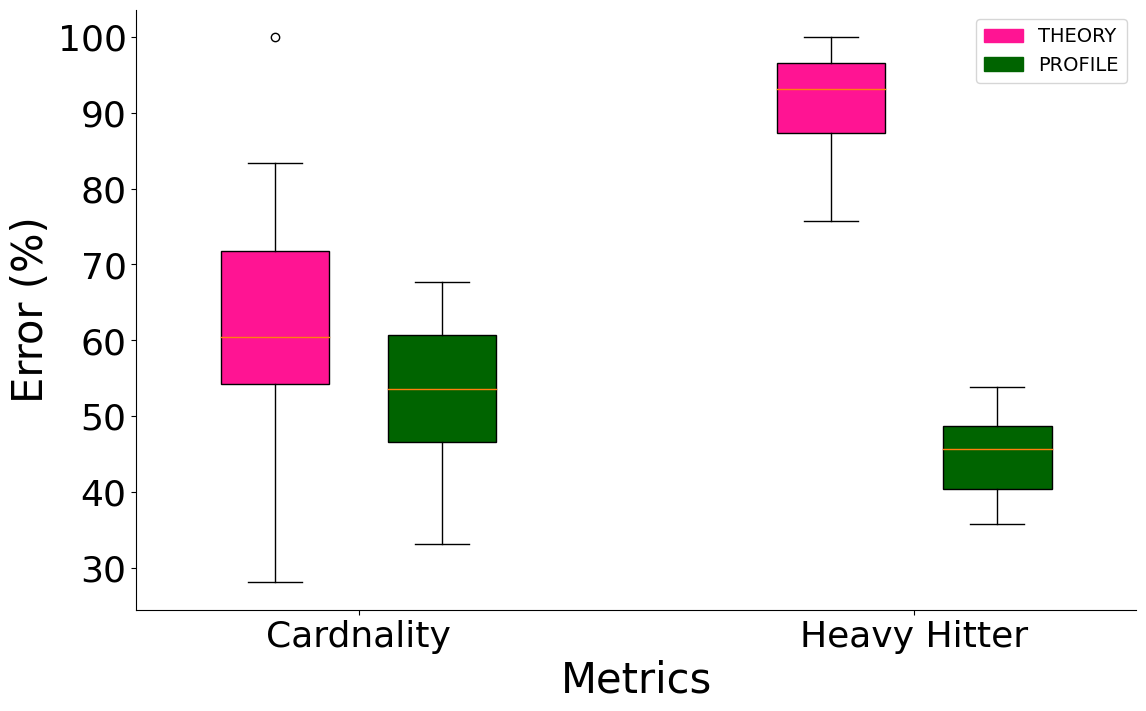

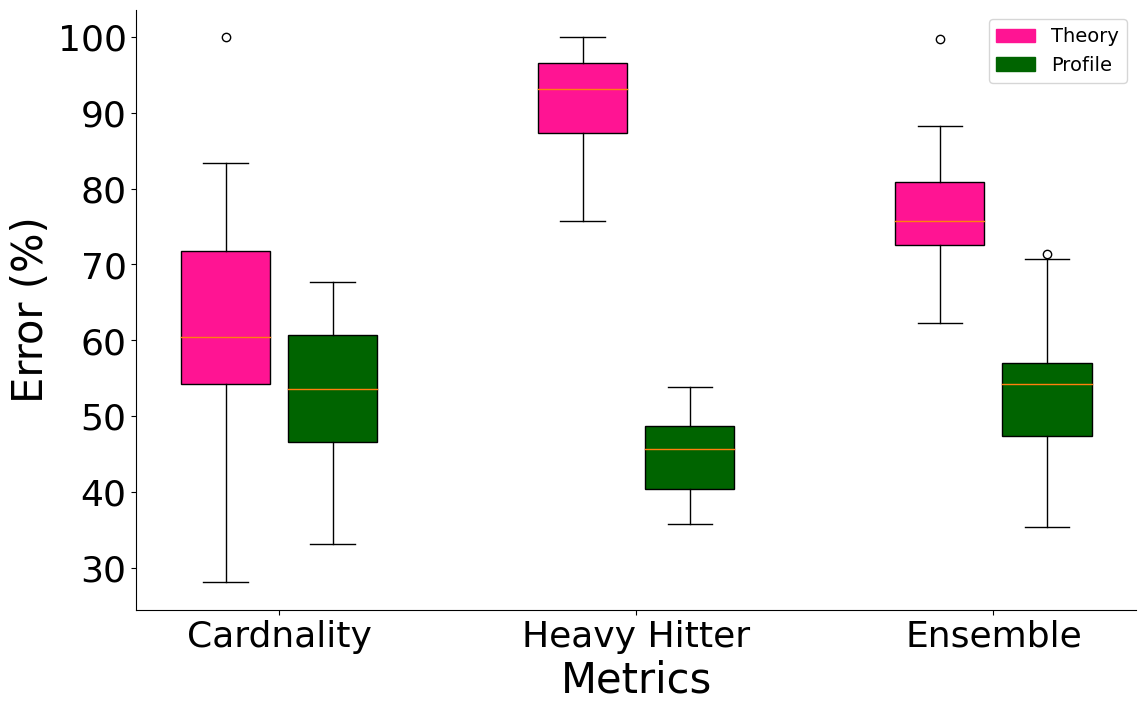

In [19]:
## pre-processing data
ret_sol1, ret_us, ret_ensemble = normalize_error_result(ret_sol1, ret_us, ret_ensemble, all_metrics)
## call plotting
plot_raw(ret_sol1, ret_us, name, all_metrics, isSaveFig)
plot_raw_with_ensemble(ret_sol1, ret_us, ret_ensemble, name, all_metrics, isSaveFig)